In [1]:
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [2]:
def gen_labels(im_name, pat1, pat2):
    '''
    Parameters
    ----------
    im_name : Str
    The image file name.
    pat1 : Str
    A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
    A string pattern in the filename 2nd class, e.g, "Nev"
    Returns
    -------
    Label : Numpy array
    Class label of the filename name based on its pattern.
    '''
    if pat1 in im_name:
        label = np.array([0])
    elif pat2 in im_name:
        label = np.array([1])
    return label

def get_data(data_path, data_list, img_h, img_w):
    """

    Parameters
    ----------
    train_data_path : Str
    Path to the data directory
    train_list : List
    A list containing the name of the images.
    img_h : Int
    image height to be resized to.
    img_w : Int
    image width to be resized to.
    Returns
    -------
    img_labels : Nested List
    A nested list containing the loaded images along with their
    correcponding labels.
    """
    img_labels = []

    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], 'Mel', 'Nev')])

        if item[0] % 100 == 0:
            print('Reading: {0}/{1} of train images'.format(item[0], len(data_list)))

    shuffle(img_labels)

    return img_labels

def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
    nested list of image arrays with corresponding class labels.
    img_h : Int
    Image height.
    img_w : Int
    Image width.
    Returns
    -------
    img_arrays : Numpy array
    4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
    1D array with the size (n_data).
    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    img_arrays = np.expand_dims(img_arrays, axis =3)
    return img_arrays, label_arrays

def get_train_test_arrays(train_data_path, test_data_path, train_list,
test_list, img_h, img_w):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """
    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)
    
    train_img, train_label = get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

In [3]:
img_w, img_h = 128, 128 # Setting the width and heights of the images.
#data_path = 'Data//DL_course//Lab1//Skin//' # Path to data root with two subdirs.
data_path = 'Data/DL_course/Lab1/Skin/' # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')

train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)

x_train, x_test, y_train, y_test = get_train_test_arrays(
    train_data_path, test_data_path,
    train_list, test_list, img_h, img_w)

#When using hinge instead of BinaryCrossEntropy as loss function 
#y_test[y_test == 0] = -1
#y_train[y_train == 0] = -1

Reading: 0/1000 of train images
Reading: 100/1000 of train images
Reading: 200/1000 of train images
Reading: 300/1000 of train images
Reading: 400/1000 of train images
Reading: 500/1000 of train images
Reading: 600/1000 of train images
Reading: 700/1000 of train images
Reading: 800/1000 of train images
Reading: 900/1000 of train images
Reading: 0/200 of train images
Reading: 100/200 of train images


In [4]:
def model(img_width, img_height, img_ch, base):
   
    model1 = Sequential()
    
    model1.add(Conv2D(filters=base, input_shape=(img_width, img_height, img_ch), kernel_size=(3,3),
    strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(2,2)))
   
    model1.add(Conv2D(filters= base *2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(2,2)))
    
    model1.add(Conv2D(filters= base *4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    
    model1.add(Conv2D(filters= base *4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    
    model1.add(Conv2D(filters= base *2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=(2,2)))
    
    model1.add(Flatten())
    model1.add(Dense(128))
    #model1.add(Dropout(0.4))
    model1.add(Activation('relu'))
    
    model1.add(Dense(64))
    #model1.add(Dropout(0.4))
    model1.add(Activation('relu'))
    
    model1.add(Dense(1))
    #model1.add(Dropout(0.4))
    model1.add(Activation('sigmoid'))
    
    model1.summary()
    
    return model1

In [5]:
img_ch = x_train[0].shape[2]
base=8

clf = model(img_w, img_h, img_ch, base)

clf.compile(loss='BinaryCrossentropy', optimizer = Adam(learning_rate = 0.00001), metrics=['binary_accuracy']) 
#clf.compile(loss='hinge', optimizer = Adam(learning_rate = 0.00001), metrics=['binary_accuracy']) 

clf_hist = clf.fit(x_train, y_train, shuffle=True, epochs = 150, batch_size = 2, verbose=1, validation_data=[x_test, y_test])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       80        
                                                                 
 activation (Activation)     (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                    

500/500 [==============================] - 4s 7ms/step - loss: 0.5013 - binary_accuracy: 0.7650 - val_loss: 0.5007 - val_binary_accuracy: 0.7800
Epoch 33/150
500/500 [==============================] - 4s 7ms/step - loss: 0.5036 - binary_accuracy: 0.7630 - val_loss: 0.5101 - val_binary_accuracy: 0.7900
Epoch 34/150
500/500 [==============================] - 4s 7ms/step - loss: 0.5024 - binary_accuracy: 0.7680 - val_loss: 0.5282 - val_binary_accuracy: 0.7400
Epoch 35/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4958 - binary_accuracy: 0.7640 - val_loss: 0.5000 - val_binary_accuracy: 0.8000
Epoch 36/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4997 - binary_accuracy: 0.7650 - val_loss: 0.5061 - val_binary_accuracy: 0.7650
Epoch 37/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4969 - binary_accuracy: 0.7720 - val_loss: 0.4895 - val_binary_accuracy: 0.8100
Epoch 38/150
500/500 [==============================] - 4s 7ms/st

Epoch 84/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4463 - binary_accuracy: 0.8020 - val_loss: 0.4615 - val_binary_accuracy: 0.8150
Epoch 85/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4417 - binary_accuracy: 0.8130 - val_loss: 0.4608 - val_binary_accuracy: 0.8250
Epoch 86/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4442 - binary_accuracy: 0.8030 - val_loss: 0.4614 - val_binary_accuracy: 0.8300
Epoch 87/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4420 - binary_accuracy: 0.8060 - val_loss: 0.4666 - val_binary_accuracy: 0.8150
Epoch 88/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4377 - binary_accuracy: 0.8070 - val_loss: 0.4698 - val_binary_accuracy: 0.8100
Epoch 89/150
500/500 [==============================] - 4s 7ms/step - loss: 0.4398 - binary_accuracy: 0.8060 - val_loss: 0.4624 - val_binary_accuracy: 0.8250
Epoch 90/150
500/500 [==============================

500/500 [==============================] - 4s 7ms/step - loss: 0.3891 - binary_accuracy: 0.8370 - val_loss: 0.4667 - val_binary_accuracy: 0.8150
Epoch 136/150
500/500 [==============================] - 4s 7ms/step - loss: 0.3873 - binary_accuracy: 0.8240 - val_loss: 0.4626 - val_binary_accuracy: 0.8150
Epoch 137/150
500/500 [==============================] - 4s 7ms/step - loss: 0.3851 - binary_accuracy: 0.8290 - val_loss: 0.4677 - val_binary_accuracy: 0.8000
Epoch 138/150
500/500 [==============================] - 4s 7ms/step - loss: 0.3834 - binary_accuracy: 0.8320 - val_loss: 0.4852 - val_binary_accuracy: 0.7900
Epoch 139/150
500/500 [==============================] - 4s 7ms/step - loss: 0.3808 - binary_accuracy: 0.8350 - val_loss: 0.4674 - val_binary_accuracy: 0.8350
Epoch 140/150
500/500 [==============================] - 4s 7ms/step - loss: 0.3778 - binary_accuracy: 0.8360 - val_loss: 0.4761 - val_binary_accuracy: 0.7950
Epoch 141/150
500/500 [==============================] - 4s 

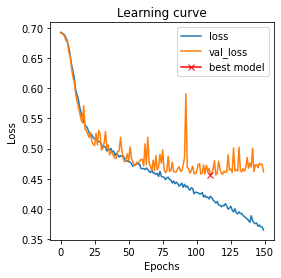

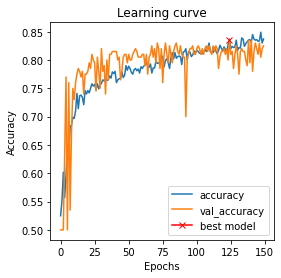

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
            np.min(clf_hist.history["val_loss"]),
            marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["binary_accuracy"], label="accuracy")
plt.plot(clf_hist.history["val_binary_accuracy"], label="val_accuracy")
plt.plot( np.argmax(clf_hist.history["val_binary_accuracy"]),
            np.max(clf_hist.history["val_binary_accuracy"]),
            marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();